# Robot predictive maintenance
Fault detection through AI and machine learning


### Problem definition and task allocations.

The problems in this project: 

- It's hard to know which tests to choose for training (moving one motor, etc.). 

- Tuning parameters such as window_size and sample_state, along with tuning the hyperparameters of all the models takes a lot of time. 

- In regression-based models, when tuning hyperparameters, grid search always chooses the smallest values. 

- If we use the call_diff function, we can't read the dataset with the utility.py function, because it removes lines with NaNS and the final submission is of a different size to the size required by the competition, so in order to use call_diff we had to read the datasets without using the function specified for this.


Tasks : 

| Member | Task | 
| --- | --- |
| Lucas Tramonte| Feature Selection, Classification and Regression models, Hyper parameters tuning | 
| --- | --- |
| Alexandre Radigue| Feature Selection | 
| --- | --- |
| Marceau Guittard | Feature Selection | 
| --- | --- |
| Matéo Lefebvre| Generate data |
| --- | --- |
| Edgar Denis| Generate data | 



# Libraries

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,accuracy_score ,precision_score, recall_score
from sklearn.metrics import f1_score,confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import warnings
from scipy.signal import butter, filtfilt

from utility import read_all_csvs_one_test
from utility import run_cv_one_motor
from utility import read_all_test_data_from_path
from utility import read_all_test_data_from_path, show_reg_result,extract_selected_feature, prepare_sliding_window, FaultDetectReg

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from functions import *

## Reading the data

### Read the training data

In [14]:
utility_path = '../'
sys.path.insert(1, utility_path)

n_int = 20

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    # Function to design a Butterworth low-pass filter
    def butter_lowpass(cutoff, fs, order=5):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a


    # Function to apply the Butterworth low-pass filter
    def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
        b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
        filtered_data = filtfilt(b, a, data)
        return filtered_data


    # Set parameters for the low-pass filter
    cutoff_frequency = 0.8  # Adjust as needed
    sampling_frequency = 10  # Assuming your data is evenly spaced in time


    def customized_outlier_removal(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].ffill()
        df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
        df['position'] = df['position'].rolling(window=20, min_periods=1).mean()
        df['position'] = df['position'].round()

        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].rolling(window=20, min_periods=1).mean()

        # Make sure that the difference between the current and previous temperature cannot be too large.
        # Define your threshold
        threshold = 0.5
        # Shift the 'temperature' column by one row to get the previous temperature
        prev_tmp = df['temperature'].shift(1)
        # Calculate the absolute difference between current and previous temperature
        temp_diff = np.abs(df['temperature'] - prev_tmp)
        # Set the temperature to NaN where the difference is larger than the threshold
        df.loc[temp_diff > threshold, 'temperature'] = np.nan
        df['temperature'] = df['temperature'].ffill()

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
        df['voltage'] = df['voltage'].ffill()
        df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
        df['voltage'] = df['voltage'].rolling(window=20, min_periods=1).mean()  
        
    def remove_seq_variability(df: pd.DataFrame):
        ''' # Description
        Remove the sequence-to-sequence variability.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]
        
    
    def cal_diff(df: pd.DataFrame, n_int: int):
        ''' # Description
        Calculate the difference between the current and previous n data point.
        '''

        # Calculate the difference between the current and previous n data point.
        df['temperature_diff'] = df['temperature'].diff(n_int)
        df['voltage_diff'] = df['voltage'].diff(n_int)
        df['position_diff'] = df['position'].diff(n_int)   

    # Start processing.
    customized_outlier_removal(df)
    remove_seq_variability(df)
    #cal_diff(df, n_int)

# Ignore warnings.
warnings.filterwarnings('ignore')

base_dictionary = '../../dataset/training_data/'
df_train = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

## Read the testing data.

Use the code below *if* you want to add the call_diff function to preprocessing : 

In [ ]:
'''
base_dictionary = '../../dataset/testing_data/'
# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list_sorted = sorted(path_list)
path_list = path_list_sorted[:-1]

# Read the data.
df_test = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    #tmp_df = read_all_csvs_one_test(path, tmp_path, pre_processing)
    
    ### ------------read_all_csvs_one_test --------------
    
    # Get a list of all CSV files in the folder
    csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]

    # Create an empty DataFrame to store the combined data
    combined_df = pd.DataFrame()

    # Iterate over the CSV files in the folder
    for file in csv_files:
        # Construct the full path to each CSV file
        file_path = os.path.join(path, file)

        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Drop the time. Will add later.
        df = df.drop(labels=df.columns[0], axis=1)

        # Apply the pre-processing.
        if pre_processing:
            pre_processing(df)

        # Extract the file name (excluding the extension) to use as a prefix
        file_name = os.path.splitext(file)[0]

        # Add a prefix to each column based on the file name
        df = df.add_prefix(f'{file_name}_')

        # Concatenate the current DataFrame with the combined DataFrame
        combined_df = pd.concat([combined_df, df], axis=1)

    # Add time and test condition
    df = pd.read_csv(file_path)
    combined_df = pd.concat([df['time'], combined_df], axis=1)

    # Calculate the time difference since the first row
    time_since_first_row = combined_df['time'] - combined_df['time'].iloc[0]
    # Replace the 'time' column with the time difference
    combined_df['time'] = time_since_first_row

    combined_df.loc[:, 'test_condition'] = tmp_path

    combined_df.drop(columns=label_columns, inplace= True)
    
    # Drop the NaN values, which represents the first n data points in the original dataframe.
    #combined_df.dropna(inplace=True)

    tmp_df = combined_df
    
    ### --------------------------------------------
    
    df_test = pd.concat([df_test, tmp_df])
    df_test = df_test.reset_index(drop=True)
    df_test.fillna(0, inplace = True)
'''

Use the code below *if* you don't want to add the call_diff function to preprocessing : 

In [15]:
base_dictionary = '../../dataset/testing_data/'
df_test = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# EDA

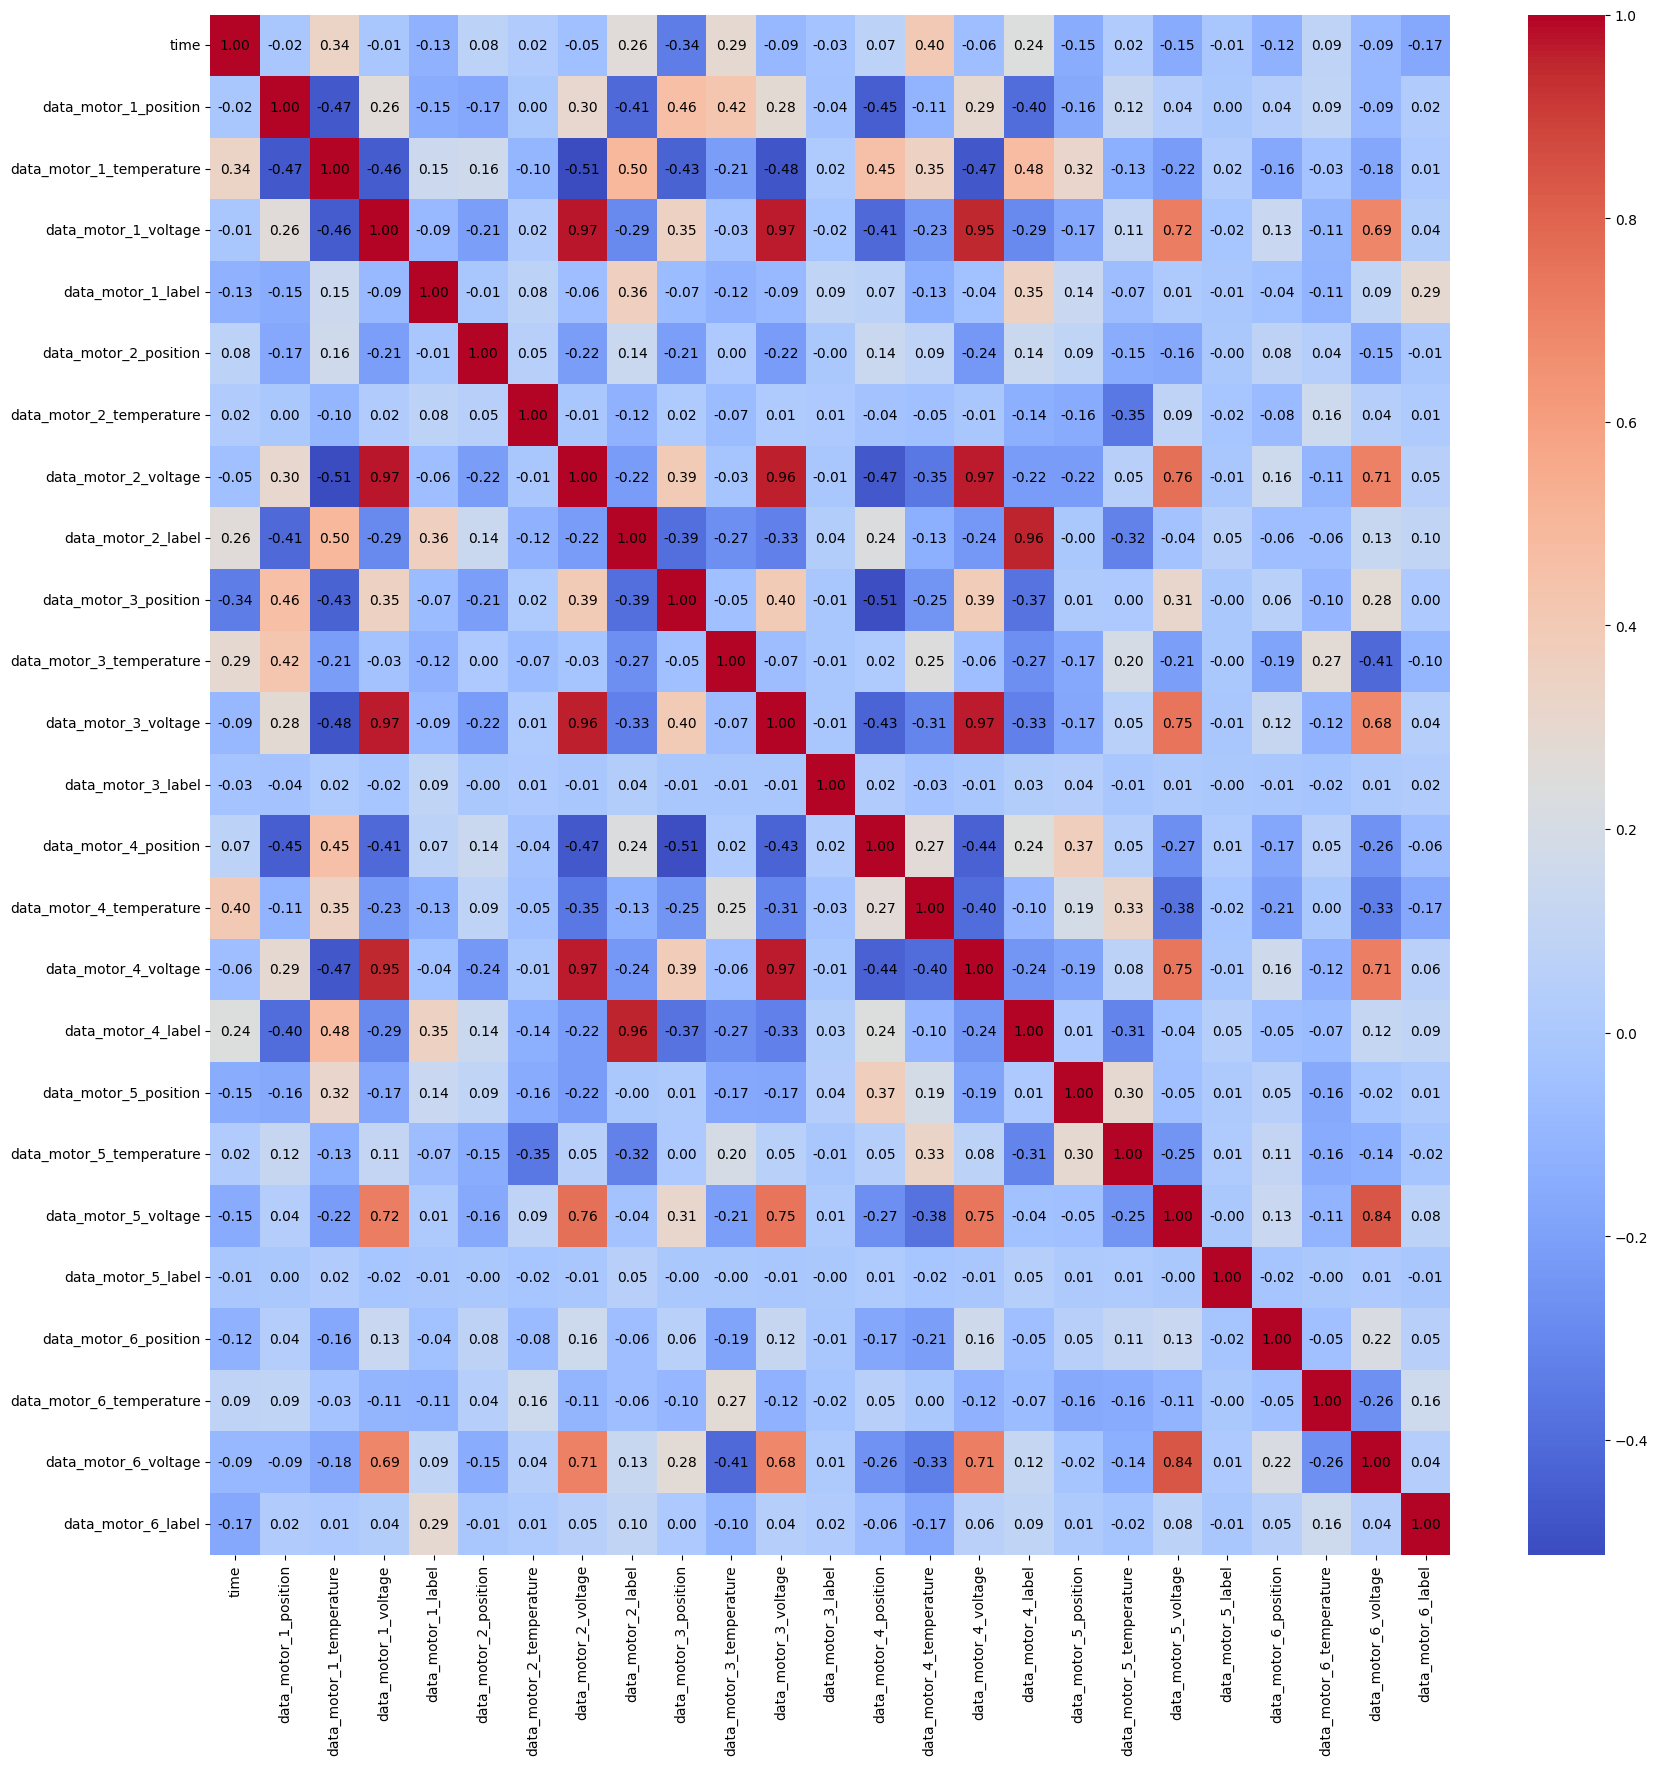

In [4]:
# Compute correlation matrix
correlation_matrix = df_train.iloc[:,:-1].corr()

# Plot correlation matrix using seaborn
plt.figure(figsize=(20, 20))  # Adjust width and height as needed
sns.heatmap(correlation_matrix, cmap='coolwarm')

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j + 0.5, i + 0.5, '{:.2f}'.format(correlation_matrix.iloc[i, j]), ha='center', va='center', color='black')

# Classification

### Specify the test conditions to include in the training.

In [56]:
#df_data_experiment_classification = df_train[df_train['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055','20240503_164675', '20240503_165189','20240503_163963', '20240325_155003'])]

# collected data : 
#'20240529_122361','20240529_122994','20240529_123223','20240529_123430','20240529_124333','20240529_125896',
#'20240529_130680','20240529_131085','20240529_131373','20240529_131558','20240529_131755','20240529_132509','20240529_133879'

#df_data_experiment_classification = df_train[df_train['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055','20240503_164675', '20240503_165189','20240503_163963', '20240325_155003','20240529_122361','20240529_122994','20240529_123223','20240529_123430','20240529_124333','20240529_125896','20240529_130680','20240529_131085','20240529_131373','20240529_131558','20240529_131755','20240529_132509','20240529_133879'])]

df_data_experiment_classification = df_train[df_train['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055','20240503_164675', '20240503_165189','20240503_163963', '20240325_155003','20240529_122361','20240529_122994','20240529_123223','20240529_123430','20240529_124333','20240529_125896','20240529_130680','20240529_131373','20240529_131755'])]

We have unbalanced data: (after we use class_weight='balanced')

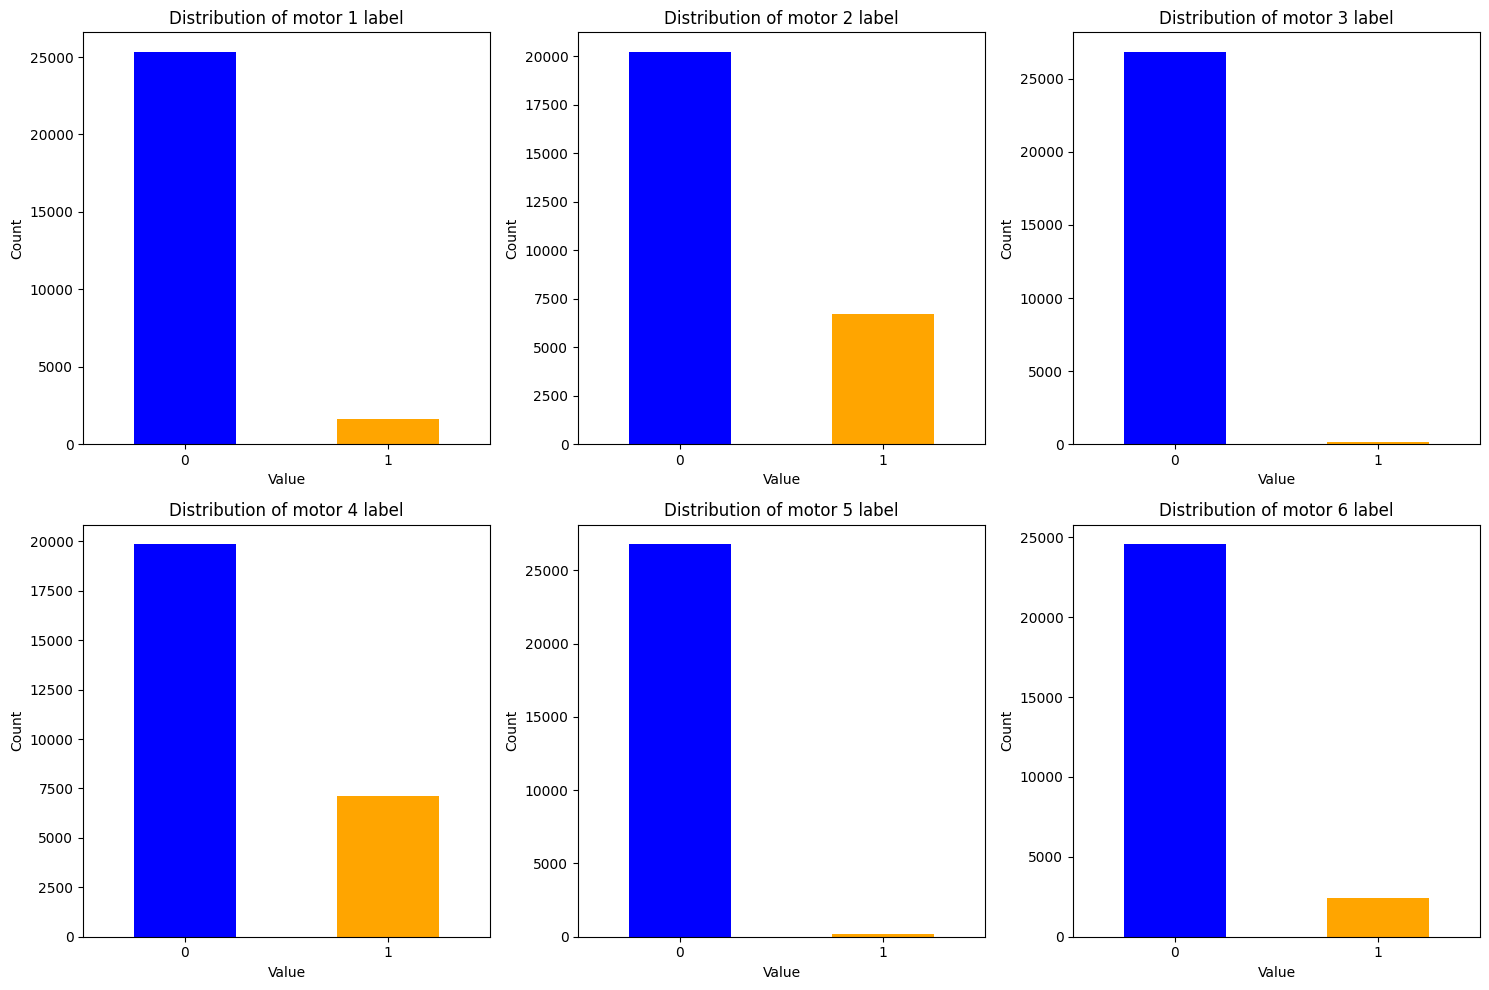

In [57]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in zip(range(1, 7), axs.flat):
    df_data_experiment_classification[f'data_motor_{i}_label'].value_counts().plot(kind='bar', color=['blue', 'orange'], ax=ax)
    ax.set_title(f'Distribution of motor {i} label')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Function for evaluation, not for submit Prediction

In [22]:
def classification_evaluation(motor_label, drop_list):
    X = df_data_experiment_classification.drop(columns=label_columns+drop_list)
    y = df_data_experiment_classification[motor_label]
    
    #X_train, y_train, X_test , y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    warnings.filterwarnings('ignore')

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
        'Random Forest': RandomForestClassifier(class_weight='balanced'),
        'Support Vector Machine': SVC(class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    # Dictionary to store model performance metrics
    model_metrics = {}

    # Define hyperparameter grids
    param_grids = {
        'Logistic Regression': {'C': [0.1, 1, 10]},
        'Decision Tree': {'max_depth': [None, 10, 20]},
        'Random Forest': {'n_estimators': [50, 100, 200]},
        'Support Vector Machine': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
        'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0]}
    }

    model_predictions = {}

    # Perform cross-validation, hyperparameter tuning, and evaluation
    for model_name, model in models.items():
        
        # Hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='f1')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        
        model_predictions[f'y_pred_{model_name.replace(" ", "_")}'] = y_pred
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store metrics in the dictionary
        model_metrics[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }
        
    # Update the summary table with the model performance metrics
    summary_table = "| Model                    | Accuracy | Precision | Recall | F1    |\n"
    summary_table += "|--------------------------|----------|-----------|--------|-------|\n"
    for model_name, metrics in model_metrics.items():
        summary_table += f"| {model_name:25} | {metrics['Accuracy']*100:.2f}%   | {metrics['Precision']*100:.2f}%   | {metrics['Recall']*100:.2f}%  | {metrics['F1']*100:.2f}% |\n"

    print(summary_table)        
    
    return model_predictions

### Apply model on testing data for submit Prediction

In [33]:
def classification_prediction(motor_label, drop_list):
        
    feature_list_all = df_data_experiment_classification.drop(columns=drop_list + ["test_condition"] + label_columns).columns.tolist()

    # Extract the features.
    df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment_classification, feature_list_all, motor_label, mdl_type='clf')

    # Prepare the training data based on the defined sliding window.
    window_size = 70
    sample_step = 30
    X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')
    
    # Define the classification model.
    
    warnings.filterwarnings('ignore')

    # Initialize models
    #models = {
    #    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    #    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    #    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    #    'Support Vector Machine': SVC(class_weight='balanced'),
    #    'Gradient Boosting': GradientBoostingClassifier()
    #}
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced'),
        'Support Vector Machine': SVC(class_weight='balanced'),
    }
    

    # Define hyperparameter grids
    #param_grids = {
    #    'Logistic Regression': {'C': [0.1, 1, 10]},
    #    'Decision Tree': {'max_depth': [20, 30]},
    #    'Random Forest': {'n_estimators': [150]},
    #    'Support Vector Machine': {'C': [0.1, 1, 10], 'gamma': ['scale']},
    #    'Gradient Boosting': {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.5, 1]}
    #}
    
    # Define hyperparameter grids
    param_grids = {
        'Support Vector Machine': {'C': [0.1, 1, 10], 'gamma': ['scale']},
        'Logistic Regression': {'C': [0.1, 1, 10]}
    }

    model_predictions = {}
    best_params = {}
    
    # Perform cross-validation, hyperparameter tuning, and evaluation
    for model_name, model in models.items():
        
        # Create the pipeline
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()), # Step 1 : Normalization
            ('model', model)
        ])
        
        param_grid = {f'model__{key}': value for key, value in param_grids[model_name].items()}
        
        # Hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
        #grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='f1')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params[model_name] = grid_search.best_params_
        
        ## Evaluate on test set
        
        feature_list_all = df_data_experiment_classification.drop(columns=label_columns+drop_list).columns.tolist()
        
        df_test_x = df_test[feature_list_all]
    
        X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')
    
        y_pred = best_model.predict(X_test)
        
        model_predictions[f'y_pred_{model_name.replace(" ", "_")}'] = y_pred    
    
    return model_predictions, best_params

# Regression

### Specify the test conditions to include in the training.

In [46]:
# Pre-train the model.
# Get all the normal data
normal_test_id = ['20240105_164214',
    '20240105_165300',
    '20240105_165972',
    '20240320_152031',
    '20240320_153841',
    '20240320_155664',
    '20240321_122650',
    '20240325_135213',
    '20240325_152902',
    '20240426_141190',
    '20240426_141532',
    '20240426_141602',
    '20240426_141726',
    '20240426_141938',
    '20240426_141980',
    '20240503_163963',
    '20240503_164435',
    '20240503_164675',
    '20240503_165189'
]

#'20240325_155003',
#'20240425_093699',
#'20240425_094425',
#'20240426_140055',

# collected data : 
#'20240529_122361','20240529_122994','20240529_123223','20240529_123430','20240529_124333','20240529_125896',
#'20240529_130680','20240529_131085','20240529_131373','20240529_131558','20240529_131755','20240529_132509','20240529_133879'
    
### After collect data : 

normal_test_id = ['20240105_164214',
    '20240105_165300',
    '20240105_165972',
    '20240320_152031',
    '20240320_153841',
    '20240320_155664',
    '20240321_122650',
    '20240325_135213',
    '20240325_152902',
    '20240426_141190',
    '20240426_141532',
    '20240426_141602',
    '20240426_141726',
    '20240426_141938',
    '20240426_141980',
    '20240503_163963',
    '20240503_164435',
    '20240503_164675',
    '20240503_165189',
    '20240529_122361',
    '20240529_123223',
    '20240529_124333',
    '20240529_125896',
    '20240529_130680',
    '20240529_131085',
    '20240529_131373',
    '20240529_131558',
    '20240529_131755',
    '20240529_132509',
    '20240529_133879'
]


df_experiment_regression = df_train[df_train['test_condition'].isin(normal_test_id)]

### Apply model on testing data for submit Prediction

In [77]:
def regression_prediction(motor_label, drop_list):
    feature_list_all = df_experiment_regression.drop(columns=drop_list + ["test_condition"] + label_columns).columns.tolist()

    #x_tr_org = SelectKBest(f_classif, k=5).fit_transform(df_experiment.drop(columns=["test_condition"] + label_columns), df_experiment[f'data_motor_{motor_label}_label'])
    
    # Prepare feature and response of the training dataset.
    x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_experiment_regression, feature_list=feature_list_all, motor_idx=motor_label, mdl_type='reg')

    # Enrich the features based on the sliding window.
    window_size = 100
    sample_step = 30
    prediction_lead_time = 5 
    threshold = 0.9
    abnormal_limit = 3

    x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')
    
    #x_tr = SelectKBest(f_classif, k=5).fit_transform(x_tr, y_temp_tr)
    
    warnings.filterwarnings('ignore')
    
    # Initialize models
    #models = {
    #    'Linear Regression': LinearRegression(),
    #    'Ridge Regression': Ridge(),
    #    'Lasso Regression': Lasso(),
    #    'ElasticNet Regression': ElasticNet(),
    #    'Decision Tree Regression': DecisionTreeRegressor(),
    #    'Gradient Boosting Regressor' : GradientBoostingRegressor()
    #}
    
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
    }
    
    #param_grids = {
        #'Linear Regression': {'n_jobs':[-1]},  
        #'Ridge Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
        #'Lasso Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
        #'ElasticNet Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.001, 0.01, 0.1, 1, 10]}, 
        #'Decision Tree Regression': {},
        #'Gradient Boosting Regressor' : {'learning_rate': [0.01], 'subsample' : [0.9],'n_estimators' : [100]}
    #}
    
    param_grids = {
        'Linear Regression': {'n_jobs':[-1]},
        'Lasso Regression': {'alpha': [0.001, 0.01, 0.5]},
    }
    
    model_predictions = {}
    best_params = {}
    
    # Perform cross-validation, hyperparameter tuning, and evaluation
    for model_name, model in models.items():
        
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()), # Step 1 : Normalization
            #('scaler', StandardScaler()), # Step 1 : Normalization
            ('model', model)
        ])
        param_grid = {f'model__{key}': value for key, value in param_grids[model_name].items()}
        
        # Hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(x_tr, y_temp_tr)
        mdl = grid_search.best_estimator_
        best_params[model_name] = grid_search.best_params_
        
        # Define the fault detector.
        detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)
        
        # Prepare the testing data.
        x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=motor_label, mdl_type='reg')
        
        #x_test_org = pd.DataFrame(SelectKBest(f_classif, k=5).fit_transform(x_test_org, y_temp_test_org))
        
        # Make predicition.
        y_pred, y_response_test_pred = detector_reg.predict(df_x_test=x_test_org, y_response_test=y_temp_test_org, complement_truncation=True)
        
        model_predictions[f'y_pred_{model_name.replace(" ", "_")}'] = y_pred 
    
    return model_predictions, best_params


# Motor 1 

### Classification

In [58]:
df_data_experiment_classification = df_train[df_train['test_condition'].isin(['20240325_152902','20240325_155003'
, '20240426_140055','20240503_164675', '20240503_165189','20240529_124333','20240529_125896','20240529_130680','20240529_131755'])]

#Feature Selection

drop_list1_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_6_position']

drop_list2_label1 = []

# Evaluation

#model_predictions = classification_evaluation('data_motor_1_label',drop_list1_label1)

# Prediction

model_predictions, best_params1 = classification_prediction(1, drop_list1_label1)
#model_predictions, best_params1 = run_all_motors_validation(1, drop_list2_label1)
#y_pred1_Gradient_Boosting = model_predictions['y_pred_Gradient_Boosting']
y_pred1_Logistic_Regression = model_predictions['y_pred_Logistic_Regression']
#y_pred1_Decision_Tree = model_predictions['y_pred_Decision_Tree']
#y_pred1_Random_Forest= model_predictions['y_pred_Random_Forest']
y_pred1_SVC= model_predictions['y_pred_Support_Vector_Machine']

print(best_params1)

{'Logistic Regression': {'model__C': 10}, 'Support Vector Machine': {'model__C': 10, 'model__gamma': 'scale'}}


### Regression

In [78]:
#Feature Selection

drop_list1_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']

drop_list2_label1 = [] # all features

drop_list3_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list4_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_2_voltage_diff', 'data_motor_3_voltage_diff', 'data_motor_4_voltage_diff', 'data_motor_5_voltage_diff', 'data_motor_6_voltage_diff']


model_predictions, best_params1 = regression_prediction(1, drop_list3_label1)


y_pred1_Linear_Regression = model_predictions['y_pred_Linear_Regression']
#y_pred1_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred1_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred1_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred1_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred1_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

print(best_params1)

100%|██████████| 8/8 [00:09<00:00,  1.14s/it]

{'Linear Regression': {'model__n_jobs': -1}, 'Lasso Regression': {'model__alpha': 0.001}}


# Motor 2

### Classification

In [59]:
df_data_experiment_classification = df_train[df_train['test_condition'].isin(['20240325_152902','20240325_155003'
, '20240426_140055','20240503_164675', '20240503_165189','20240529_124333','20240529_125896','20240529_130680'])]

drop_list1_label2 = ['data_motor_1_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_5_temperature']

drop_list2_label2 = []

# Evaluation

#model_predictions = classification_evaluation('data_motor_2_label',drop_list1_label2)

# Prediction

model_predictions, best_params2 = classification_prediction(2, drop_list1_label2)
#model_predictions, best_params2 = run_all_motors_validation(2, drop_list2_label2)

#y_pred2_Gradient_Boosting = model_predictions['y_pred_Gradient_Boosting'] # a minimum of 2 classes are required.
y_pred2_Logistic_Regression = model_predictions['y_pred_Logistic_Regression'] # The number of classes has to be greater than one; got 1 class
#y_pred2_Decision_Tree = model_predictions['y_pred_Decision_Tree']
#y_pred2_Random_Forest= model_predictions['y_pred_Random_Forest']
y_pred2_SVC= model_predictions['y_pred_Support_Vector_Machine'] # The number of classes has to be greater than one; got 1 class

print(best_params2)

{'Logistic Regression': {'model__C': 0.1}, 'Support Vector Machine': {'model__C': 1, 'model__gamma': 'scale'}}


### Regression

In [79]:
## Feature Selection

drop_list1_label2 = ['data_motor_1_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_5_temperature']

drop_list2_label2 = []

drop_list3_label2 = ['data_motor_1_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list4_label2 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_2_voltage_diff', 'data_motor_3_voltage_diff', 'data_motor_4_voltage_diff', 'data_motor_5_voltage_diff', 'data_motor_6_voltage_diff']

model_predictions, best_params2 = regression_prediction(2, drop_list3_label2)

y_pred2_Linear_Regression = model_predictions['y_pred_Linear_Regression']
#y_pred2_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred2_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred2_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred2_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred2_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

print(best_params2)

100%|██████████| 8/8 [00:10<00:00,  1.29s/it]

{'Linear Regression': {'model__n_jobs': -1}, 'Lasso Regression': {'model__alpha': 0.001}}


# Motor 3

### Classification

In [60]:
df_data_experiment_classification = df_train[df_train['test_condition'].isin(['20240325_152902','20240325_155003'
, '20240426_140055','20240503_164675', '20240503_165189','20240529_124333','20240529_125896','20240529_130680'])]

## Feature Selection
drop_list1_label3 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']
drop_list2_label3 = []

## Evaluation
# model_predictions = classification_evaluation('data_motor_2_label',drop_list1_label2)

## Prediction
model_predictions, best_params3 = classification_prediction(3, drop_list1_label3)

#y_pred3_Gradient_Boosting = model_predictions['y_pred_Gradient_Boosting']
y_pred3_Logistic_Regression = model_predictions['y_pred_Logistic_Regression']
#y_pred3_Decision_Tree = model_predictions['y_pred_Decision_Tree']
#y_pred3_Random_Forest= model_predictions['y_pred_Random_Forest']
y_pred3_SVC= model_predictions['y_pred_Support_Vector_Machine']

print(best_params3)

{'Logistic Regression': {'model__C': 10}, 'Support Vector Machine': {'model__C': 10, 'model__gamma': 'scale'}}


### Regression

In [80]:
## Feature Selection

drop_list1_label3 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']

drop_list2_label3 = []

drop_list3_label3 = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list4_label3 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_2_voltage_diff', 'data_motor_3_voltage_diff', 'data_motor_4_voltage_diff', 'data_motor_5_voltage_diff', 'data_motor_6_voltage_diff']

## Prediction

model_predictions, best_params3 = regression_prediction(3, drop_list3_label3)


y_pred3_Linear_Regression = model_predictions['y_pred_Linear_Regression']
#y_pred3_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred3_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred3_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred3_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred3_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

print(best_params3)

100%|██████████| 8/8 [00:08<00:00,  1.11s/it]

{'Linear Regression': {'model__n_jobs': -1}, 'Lasso Regression': {'model__alpha': 0.001}}


# Motor 4

### Classification

In [61]:
df_data_experiment_classification = df_train[df_train['test_condition'].isin(['20240325_152902','20240325_155003'
, '20240426_140055','20240503_164675', '20240503_165189','20240529_124333','20240529_125896','20240529_130680','20240529_131373'])]

## Feature Selection
drop_list1_label4= ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_5_temperature']
drop_list2_label4 = []

## Evaluation
#model_predictions = classification_evaluation('data_motor_4_label',drop_list1_label4)

## Prediction
model_predictions,best_params4 = classification_prediction(4, drop_list1_label4)

#y_pred4_Gradient_Boosting = model_predictions['y_pred_Gradient_Boosting']
y_pred4_Logistic_Regression = model_predictions['y_pred_Logistic_Regression']
#y_pred4_Decision_Tree = model_predictions['y_pred_Decision_Tree']
#y_pred4_Random_Forest= model_predictions['y_pred_Random_Forest']
y_pred4_SVC= model_predictions['y_pred_Support_Vector_Machine']

print(best_params4)

{'Logistic Regression': {'model__C': 0.1}, 'Support Vector Machine': {'model__C': 1, 'model__gamma': 'scale'}}


### Regression

In [81]:
normal_test_id = ['20240105_164214',
    '20240105_165300',
    '20240105_165972',
    '20240320_152031',
    '20240320_153841',
    '20240320_155664',
    '20240321_122650',
    '20240325_135213',
    '20240325_152902',
    '20240426_141190',
    '20240426_141532',
    '20240426_141602',
    '20240426_141726',
    '20240426_141938',
    '20240426_141980',
    '20240503_164435',
    '20240529_122361',
    '20240529_123223',
    '20240529_124333',
    '20240529_125896',
    '20240529_130680',
    '20240529_131085',
    '20240529_131558',
    '20240529_131755',
    '20240529_132509',
    '20240529_133879'
]


df_experiment_regression = df_train[df_train['test_condition'].isin(normal_test_id)]

## Feature Selection

drop_list1_label4= ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage','data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_5_temperature']

drop_list2_label4 = []

drop_list3_label4 = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list4_label4 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_2_voltage_diff', 'data_motor_3_voltage_diff', 'data_motor_4_voltage_diff', 'data_motor_5_voltage_diff', 'data_motor_6_voltage_diff']

## Prediction

model_predictions,best_params4 = regression_prediction(4, drop_list3_label4)


y_pred4_Linear_Regression = model_predictions['y_pred_Linear_Regression']
#y_pred4_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred4_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred4_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred4_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred4_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

print(best_params4)

100%|██████████| 8/8 [00:08<00:00,  1.09s/it]

{'Linear Regression': {'model__n_jobs': -1}, 'Lasso Regression': {'model__alpha': 0.001}}


# Motor 5

### Classification

In [63]:
df_data_experiment_classification = df_train[df_train['test_condition'].isin(['20240325_152902','20240325_155003'
, '20240426_140055','20240503_164675', '20240503_165189','20240529_124333','20240529_125896','20240529_130680'])]

## Feature Selection
drop_list1_label5 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_6_voltage']
drop_list2_label5 = []

## Evaluation
#model_predictions = classification_evaluation('data_motor_5_label',drop_list1_label5)

## Prediction
model_predictions, best_params5 = classification_prediction(5, drop_list3_label5)
#model_predictions, best_params5 = run_all_motors_validation(5, drop_list2_label5)

#y_pred5_Gradient_Boosting = model_predictions['y_pred_Gradient_Boosting']
y_pred5_Logistic_Regression = model_predictions['y_pred_Logistic_Regression']
#y_pred5_Decision_Tree = model_predictions['y_pred_Decision_Tree']
#y_pred5_Random_Forest= model_predictions['y_pred_Random_Forest']
y_pred5_SVC= model_predictions['y_pred_Support_Vector_Machine']

print(best_params5)

{'Logistic Regression': {'model__C': 10}, 'Support Vector Machine': {'model__C': 1, 'model__gamma': 'scale'}}


### Regression

In [82]:
## Feature Selection
drop_list1_label5 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_6_voltage']

drop_list2_label5 = []

drop_list3_label5 = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list4_label5 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_2_voltage_diff', 'data_motor_3_voltage_diff', 'data_motor_4_voltage_diff', 'data_motor_5_voltage_diff', 'data_motor_6_voltage_diff']

## Prediction
model_predictions,best_params5 = regression_prediction(5, drop_list3_label5)

y_pred5_Linear_Regression = model_predictions['y_pred_Linear_Regression']
#y_pred5_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred5_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred5_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred5_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred5_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

print(best_params5)

100%|██████████| 8/8 [00:09<00:00,  1.21s/it]

{'Linear Regression': {'model__n_jobs': -1}, 'Lasso Regression': {'model__alpha': 0.001}}


# Motor 6

### Classification

In [64]:
df_data_experiment_classification = df_train[df_train['test_condition'].isin(['20240325_152902','20240325_155003'
, '20240426_140055','20240503_163963','20240503_164435','20240503_164675', '20240503_165189','20240529_122361','20240529_122994','20240529_123223','20240529_123430','20240529_124333','20240529_125896','20240529_130680'])]

## Feature Selection
drop_list1_label6 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_position']
drop_list2_label6 = []

## Evaluation
#model_predictions = classification_evaluation('data_motor_6_label',drop_list1_label6)

## Prediction
model_predictions, best_params6 = classification_prediction(6, drop_list1_label6)

#y_pred6_Gradient_Boosting = model_predictions['y_pred_Gradient_Boosting']
y_pred6_Logistic_Regression = model_predictions['y_pred_Logistic_Regression']
#y_pred6_Decision_Tree = model_predictions['y_pred_Decision_Tree']
#y_pred6_Random_Forest= model_predictions['y_pred_Random_Forest']
y_pred6_SVC= model_predictions['y_pred_Support_Vector_Machine']

print(best_params6)

{'Logistic Regression': {'model__C': 0.1}, 'Support Vector Machine': {'model__C': 10, 'model__gamma': 'scale'}}


### Regression

In [83]:
normal_test_id = ['20240105_164214',
    '20240105_165300',
    '20240105_165972',
    '20240320_152031',
    '20240320_153841',
    '20240320_155664',
    '20240321_122650',
    '20240325_135213',
    '20240325_152902',
    '20240426_141190',
    '20240426_141532',
    '20240426_141602',
    '20240426_141726',
    '20240426_141938',
    '20240426_141980',
    '20240503_164435',
    '20240529_122361',
    '20240529_123223',
    '20240529_124333',
    '20240529_125896',
    '20240529_130680',
    '20240529_131085',
    '20240529_131373',
    '20240529_131558',
    '20240529_131755',
    '20240529_132509',
    '20240529_133879'
]


df_experiment_regression = df_train[df_train['test_condition'].isin(normal_test_id)]



##Feature Selection

drop_list1_label6 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_position']

drop_list2_label6 = []

drop_list3_label6 = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list4_label6 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_2_voltage_diff', 'data_motor_3_voltage_diff', 'data_motor_4_voltage_diff', 'data_motor_5_voltage_diff', 'data_motor_6_voltage_diff']

## Prediction
model_predictions,best_params6 = regression_prediction(6, drop_list3_label6)


y_pred6_Linear_Regression = model_predictions['y_pred_Linear_Regression']
#y_pred6_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred6_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred6_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred6_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred6_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

print(best_params6)

100%|██████████| 8/8 [00:09<00:00,  1.23s/it]

{'Linear Regression': {'model__n_jobs': -1}, 'Lasso Regression': {'model__alpha': 0.001}}


# Create csv file for submit Prediction

### Regression

Linear_Regression

In [75]:
data_Linear_Regression = {
    'idx': range(len(y_pred1_Linear_Regression)),
    'data_motor_1_label': y_pred1_Linear_Regression,
    'data_motor_2_label': y_pred2_Linear_Regression,
    'data_motor_3_label': y_pred3_Linear_Regression,
    'data_motor_4_label': y_pred4_Linear_Regression,
    'data_motor_5_label': y_pred5_Linear_Regression,
    'data_motor_6_label': y_pred6_Linear_Regression
}

df_Linear_Regression = pd.DataFrame(data_Linear_Regression)

df_Linear_Regression.to_csv('motor_predictions_Linear_Regression.csv', index=False)

Ridge_Regression

In [43]:
data_Ridge_Regression = {
    'idx': range(len(y_pred1_Ridge_Regression)),
    'data_motor_1_label': y_pred1_Ridge_Regression,
    'data_motor_2_label': y_pred2_Ridge_Regression,
    'data_motor_3_label': y_pred3_Ridge_Regression,
    'data_motor_4_label': y_pred4_Ridge_Regression,
    'data_motor_5_label': y_pred5_Ridge_Regression,
    'data_motor_6_label': y_pred6_Ridge_Regression
}

df_Ridge_Regression = pd.DataFrame(data_Ridge_Regression)

df_Ridge_Regression.to_csv('motor_predictions_Ridge_Regression.csv', index=False)

Lasso_Regression

In [84]:
data_Lasso_Regression = {
    'idx': range(len(y_pred1_Lasso_Regression)),
    'data_motor_1_label': y_pred1_Lasso_Regression,
    'data_motor_2_label': y_pred2_Lasso_Regression,
    'data_motor_3_label': y_pred3_Lasso_Regression,
    'data_motor_4_label': y_pred4_Lasso_Regression,
    'data_motor_5_label': y_pred5_Lasso_Regression,
    'data_motor_6_label': y_pred6_Lasso_Regression
}

df_Lasso_Regression = pd.DataFrame(data_Lasso_Regression)

df_Lasso_Regression.to_csv('motor_predictions_Lasso_Regression.csv', index=False)

ElasticNet_Regression

In [ ]:
data_ElasticNet_Regression = {
    'idx': range(len(y_pred1_ElasticNet_Regression)),
    'data_motor_1_label': y_pred1_ElasticNet_Regression,
    'data_motor_2_label': y_pred2_ElasticNet_Regression,
    'data_motor_3_label': y_pred3_ElasticNet_Regression,
    'data_motor_4_label': y_pred4_ElasticNet_Regression,
    'data_motor_5_label': y_pred5_ElasticNet_Regression,
    'data_motor_6_label': y_pred6_ElasticNet_Regression
}

df_ElasticNet_Regression = pd.DataFrame(data_ElasticNet_Regression)

df_ElasticNet_Regression.to_csv('motor_predictions_ElasticNet_Regression.csv', index=False)

Decision_Tree_Regression

In [ ]:
data_Decision_Tree_Regression = {
    'idx': range(len(y_pred1_Decision_Tree_Regression)),
    'data_motor_1_label': y_pred1_Decision_Tree_Regression,
    'data_motor_2_label': y_pred2_Decision_Tree_Regression,
    'data_motor_3_label': y_pred3_Decision_Tree_Regression,
    'data_motor_4_label': y_pred4_Decision_Tree_Regression,
    'data_motor_5_label': y_pred5_Decision_Tree_Regression,
    'data_motor_6_label': y_pred6_Decision_Tree_Regression
}

df_Decision_Tree_Regression = pd.DataFrame(data_Decision_Tree_Regression)

df_Decision_Tree_Regression.to_csv('motor_predictions_Decision_Tree_Regression.csv', index=False)

Gradient_Boosting_Regressor

In [ ]:
data_Gradient_Boosting_Regressor = {
    'idx': range(len(y_pred1_Gradient_Boosting_Regressor)),
    'data_motor_1_label': y_pred1_Gradient_Boosting_Regressor,
    'data_motor_2_label': y_pred2_Gradient_Boosting_Regressor,
    'data_motor_3_label': y_pred3_Gradient_Boosting_Regressor,
    'data_motor_4_label': y_pred4_Gradient_Boosting_Regressor,
    'data_motor_5_label': y_pred5_Gradient_Boosting_Regressor,
    'data_motor_6_label': y_pred6_Gradient_Boosting_Regressor
}

df_Gradient_Boosting_Regressor = pd.DataFrame(data_Gradient_Boosting_Regressor)

df_Gradient_Boosting_Regressor.to_csv('motor_predictions_Gradient_Boosting_Regressor.csv', index=False)

### Summary of the best results - Regression

| Model   | Tests | Rem seq variability | Drop_list  | window_size | sample_step | lead_time |threshold | abnormal_limit | F1   |
|---------|-------|---------------------|------------|-------------|-------------|----------------------|----------|----------------|------|
| Linear Regression | all - collected| No | 2 | 70 | 30 | 5 | .9 | 3 | 0.33 |
| Ridge  |all - collected| No | 2 | 70 | 30 | 5 | .9 | 3 | 0.37|
| Lasso  |all| Yes | 1 | 70 | 30 | 5 | .9 | 3 | 0.46|
| ElasticNet  |all - collected| No | 2 | 70 | 30 | 5 | .9 | 3 | 0.24 |
| Decision Tree Reg |all - collected|No | 2 | 70 | 30 | 5 | .9 | 3 | 0.19 |
| Gradient_Boosting_Reg |all - collected| No | 2 | 70 | 30 | 5 | .9 | 3 | 0.15 |

### Classification

Logistic_Regression

In [65]:
data_Logistic_Regression = {
    'idx': range(len(y_pred1_Logistic_Regression)),
    'data_motor_1_label': y_pred1_Logistic_Regression,
    'data_motor_2_label': y_pred2_Logistic_Regression,
    'data_motor_3_label': y_pred3_Logistic_Regression,
    'data_motor_4_label': y_pred4_Logistic_Regression,
    'data_motor_5_label': y_pred5_Logistic_Regression,
    'data_motor_6_label': y_pred6_Logistic_Regression
}

df_Logistic_Regression = pd.DataFrame(data_Logistic_Regression)
df_Logistic_Regression.to_csv('motor_predictions_Logistic_Regression.csv', index=False)

Support Vector Machine

In [66]:
data_SVC = {
    'idx': range(len(y_pred1_SVC)),
    'data_motor_1_label': y_pred1_SVC,
    'data_motor_2_label': y_pred2_SVC,
    'data_motor_3_label': y_pred3_SVC,
    'data_motor_4_label': y_pred4_SVC,
    'data_motor_5_label': y_pred5_SVC,
    'data_motor_6_label': y_pred6_SVC
}

df_SVC = pd.DataFrame(data_SVC)

df_SVC.to_csv('motor_predictions_SVC.csv', index=False)

Gradient_Boosting

In [ ]:
data_Gradient_Boosting = {
    'idx': range(len(y_pred1_Gradient_Boosting)),
    'data_motor_1_label': y_pred1_Gradient_Boosting,
    'data_motor_2_label': y_pred2_Gradient_Boosting,
    'data_motor_3_label': y_pred3_Gradient_Boosting,
    'data_motor_4_label': y_pred4_Gradient_Boosting,
    'data_motor_5_label': y_pred5_Gradient_Boosting,
    'data_motor_6_label': y_pred6_Gradient_Boosting
}

df_Gradient_Boosting = pd.DataFrame(data_Gradient_Boosting)

df_Gradient_Boosting.to_csv('motor_predictions_Gradient_Boosting.csv', index=False)

Random_Forest

In [ ]:
data_Random_Forest = {
    'idx': range(len(y_pred1_Random_Forest)),
    'data_motor_1_label': y_pred1_Random_Forest,
    'data_motor_2_label': y_pred2_Random_Forest,
    'data_motor_3_label': y_pred2_Random_Forest,
    'data_motor_4_label': y_pred4_Random_Forest,
    'data_motor_5_label': y_pred5_Random_Forest,
    'data_motor_6_label': y_pred6_Random_Forest
}

df_Random_Forest = pd.DataFrame(data_Random_Forest)

df_Random_Forest.to_csv('motor_predictions_Random_Forest.csv', index=False)

Decision_Tree

In [ ]:
data_Decision_Tree = {
    'idx': range(len(y_pred1_Decision_Tree)),
    'data_motor_1_label': y_pred1_Decision_Tree,
    'data_motor_2_label': y_pred2_Decision_Tree,
    'data_motor_3_label': y_pred3_Decision_Tree,
    'data_motor_4_label': y_pred4_Decision_Tree,
    'data_motor_5_label': y_pred5_Decision_Tree,
    'data_motor_6_label': y_pred6_Decision_Tree
}

df_Decision_Tree = pd.DataFrame(data_Decision_Tree)

df_Decision_Tree.to_csv('motor_predictions_Decision_Tree.csv', index=False)

### Summary of the best results - Classification

| Model   | Drop_list | window_size | sample_step | F1   |
|---------|----------|-------------|-------------|------|
| Logistic Regression | 2 | 70 | 30 | 0.37|
| SVC | 2 | 70 | 30 | 0.45|
| Random Forest | 2 | 70 | 30 | 0.13 | 
| Decision Tree  |  2 | 70 | 30 |  0.19 | 
| Gradient Boosting  |  2 | 70 | 30 | 0.12 | 